# The Ruth Finley Collection: Digitizing 70 Years of the Fashion Calendar

In [ ]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
from pathlib import Path
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from itertools import groupby
import pandas as pd
import PyPDF2
from scipy.spatial.distance import pdist, cdist

In [ ]:
from functions import (
    transform_coordinates, transform_coordinates, element, filter_by_x_and_y, colormap
)

In [ ]:
azure_results_directory = Path(r'C:\Users\Nicolas\Documents\fashion\azure_json')
pdf_directory = Path(r'C:\Users\Nicolas\Documents\fashion\pdf')
image_directory = Path('C:/Users/Nicolas/Documents/Fashion/images')

#### Functions

Get an element that matches an exact string

In [ ]:
def get_key_from_text(lines, string):
    lines = list(filter(lambda x: x.text == string, lines))
    return lines

Function to see if all the string is capitalized, which we will use to recognize the four columns: `"DATE"`, `"WHAT'S GOING ON"`, `"GIVEN BY"`, `"WHERE"`

In [ ]:
def is_all_caps(string):
    return all(map(str.isupper, filter(str.isalpha, string)))

## <font color='mediumseagreen'>Inference</font>

In [ ]:
all_images = list(image_directory.glob('*/*'))

In [ ]:
image_path = np.random.choice(all_images)

In [ ]:
page_num = image_path.with_suffix('').name

## <font color='mediumseagreen'>Non-Random Part</font>

Converting a page from the PDF to a NumPy array

In [ ]:
image = plt.imread(image_path)

In [ ]:
height, width, channels = image.shape

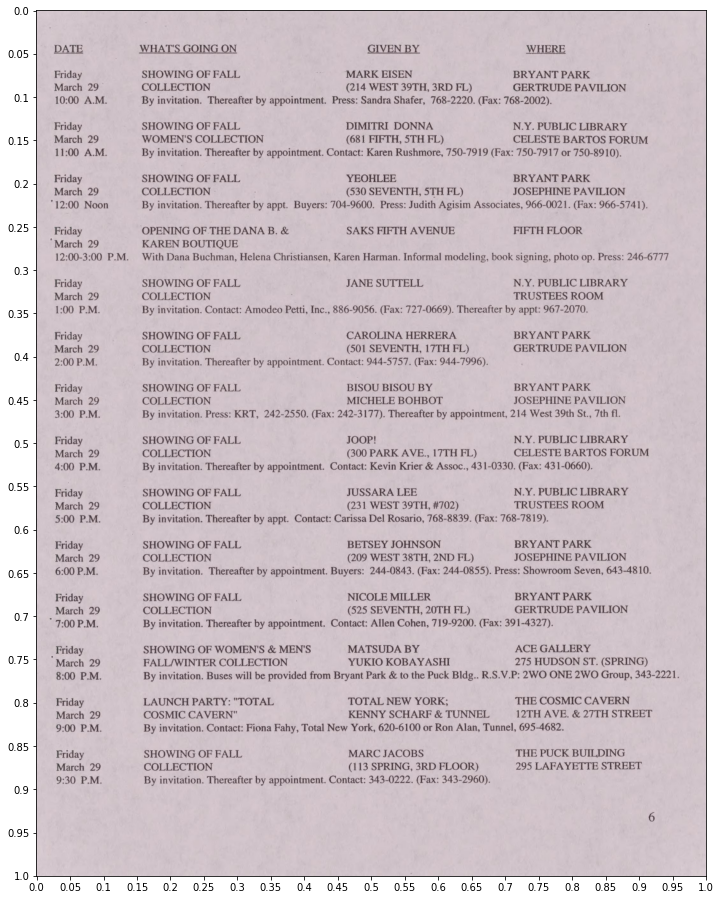

In [ ]:
plt.figure(figsize=(12, 16))
plt.imshow(image)
plt.xticks(np.linspace(0, width,  21), (np.linspace(0, width,  21) /  width).round(3))
plt.yticks(np.linspace(0, height, 21), (np.linspace(0, height, 21) / height).round(3))
plt.show()

Loading the OCR result

In [ ]:
with open(str(azure_results_directory / image_path.parents[0].name) + '.json') as file:
    result = json.load(file)

In [ ]:
transformed_lines = result[str(page_num)]['lines']
transformed_words = result[str(page_num)]['words']

transformed_lines = list(map(lambda x: element(**x), transformed_lines))
transformed_words = list(map(lambda x: element(**x), transformed_words))

Gets the column key `"DATE"`

In [ ]:
[when_keys] = get_key_from_text(transformed_words, 'DATE')
*_, xmin_when, xmax_when, ymin_when, ymax_when = when_keys

Gets the column key `"WHAT'S GOING ON"`

In [ ]:
[what_keys] = get_key_from_text(transformed_lines, "WHAT'S GOING ON")
*_, xmin_what, xmax_what, ymin_what, ymax_what = what_keys

Gets the column key `"GIVEN BY"`

In [ ]:
[who_keys] = get_key_from_text(transformed_lines, 'GIVEN BY')
*_, xmin_who, xmax_who, ymin_who, ymax_who = who_keys

Gets the column key `"WHERE"`

In [ ]:
[where_keys] = get_key_from_text(transformed_lines, 'WHERE')
*_, xmin_where, xmax_where, ymin_where, ymax_where =  where_keys

Since we are using static rules to detect columns, this can create problems if the document is slightly tilted. The adjustment broadens the search zone slightly so elements aren't ignored as soon as they are not perfectly under the column keywords.

In [ ]:
adjustment = 0.05
small_adjustment = 0.0

Getting the column delimitations for the four respective fields

In [ ]:
when_x_min = 0.
when_x_max = xmin_what

what_x_min = xmin_what - 0.025
what_x_max = xmin_who + small_adjustment

who_x_min = xmin_who - adjustment
who_x_max = xmin_where + small_adjustment

where_x_min = xmin_where - adjustment
where_x_max = 1.

In [ ]:
columns = {
    0: (when_x_min, when_x_max),
    1: (what_x_min, what_x_max),
    2: (who_x_min, who_x_max),
    3: (where_x_min, where_x_max)
}

Getting preliminary `Y` coordinate limits. This starts at the column keywords and ends at the bottom of the page.

In [ ]:
when_y_min = ymin_when
when_y_max = 1

what_y_min = ymin_what
what_y_max = 1

who_y_min = ymin_who
who_y_max = 1

where_y_min = ymin_where
where_y_max = 1

Post-processing: separating lines and words and standardizing them

Exclusion of things that occur

In [ ]:
transformed_lines = list(filter(lambda x: 'WEEK BEGINNING' not in x.text, transformed_lines))
transformed_lines = list(filter(lambda x: 'WEEK ENDING' not in x.text, transformed_lines))

In [ ]:
page_number = list(filter(lambda x: len(x.text) < 5 and
                          x.ymin > 0.9 and
                          x.xmin > 0.8 and
                          len(set(x.text).intersection('0123456789')),
                          transformed_lines))
if page_number:
    page_number_height = min(map(lambda x: x.ymin, page_number))
else:
    page_number_height = 1

In [ ]:
if page_number:
    transformed_lines = filter_by_x_and_y(transformed_lines, ymax=page_number_height)
    transformed_words = filter_by_x_and_y(transformed_words, ymax=page_number_height)

In [ ]:
cont_showings = list(filter(lambda x: 'CONTINUOUS SHOWINGS' in x.text, transformed_lines))
if cont_showings:
    cont_showings_height = min(map(lambda x: x.ymin, cont_showings))
else:
    cont_showings_height = 1

In [ ]:
if cont_showings:
    transformed_lines = filter_by_x_and_y(transformed_lines, ymax=cont_showings_height)
    transformed_words = filter_by_x_and_y(transformed_words, ymax=cont_showings_height)

In [ ]:
highest_of_col_info = max(list(map(lambda x: x.ymax, [when_keys, what_keys, who_keys, where_keys])))

In [ ]:
transformed_lines = filter_by_x_and_y(transformed_lines, ymin=highest_of_col_info)
transformed_words = filter_by_x_and_y(transformed_words, ymin=highest_of_col_info)

Displaying column splits

Looking for the `"Copyright"` string that means end of interesting page content (if found)

In [ ]:
end_of_page = 0.90

Removing all elements below the `"Copyright"` string

In [ ]:
last_tenth = list(filter(lambda x: x.ymin > end_of_page, transformed_lines))
copyright = list(filter(lambda x: x.text.startswith('Copyright'), last_tenth))
if copyright:
    print('Copyright found.')
    ymin_copyright = min(copyright[0].ymin, page_number_height)
    transformed_lines = list(filter(lambda x: x.ymax < ymin_copyright, transformed_lines))
    transformed_words = list(filter(lambda x: x.ymax < ymin_copyright, transformed_words))
else:
    ymin_copyright = min(page_number_height, 1)

In [ ]:
y_limit = ymin_copyright

In [ ]:
transformed_words = filter_by_x_and_y(transformed_words, ymax=y_limit)
transformed_lines = filter_by_x_and_y(transformed_lines, ymax=y_limit)

For all column search zones, extract the subset of words or lines that resides in the corresponding search zone

Visualizing elements that fit into different columns

Clustering lines in the columns date as one being the continuity of the previous one

In [ ]:
filtered_when = filter_by_x_and_y(
    transformed_words,
    when_x_min,
    when_x_max
)

In [ ]:
points = np.array(list(map(lambda x: (x.ymin, x.ymax), filtered_when)))

In [ ]:
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.025, linkage='single')
agg_clustering = agg_clustering.fit(points)

clusters = agg_clustering.fit_predict(points)

new_clusters = []
for ix, group in enumerate([list(g) for k, g in groupby(clusters)]):
    new_clusters.extend(np.repeat(ix, len(group)).tolist())

In [ ]:
grouped_lines = defaultdict(lambda: list())

for line, group in zip(filtered_when, new_clusters):
    grouped_lines[group].append(line)
grouped_lines = dict(grouped_lines)

In [ ]:
minimum_of_groups = []
for cluster, group in grouped_lines.items():
    minimum_of_group = min(map(lambda x: x.ymin, group))
    minimum_of_groups.append(minimum_of_group)

Make groups of elements based on results from clustering

Sort groups of date elements by their location on the page

In [ ]:
grouped_lines = defaultdict(lambda: list())

for line, group in zip(transformed_lines, new_clusters):
    grouped_lines[group].append(line)
grouped_lines = dict(grouped_lines)

Based on the groups, split page elements in rows/blocks

In [ ]:
rows = {}
for ix, minimum in enumerate(minimum_of_groups):
    if ix < len(minimum_of_groups) - 1:
        rows[ix] = (minimum, minimum_of_groups[ix + 1])
    else:
        rows[ix] = (minimum, y_limit)

In [ ]:
rows

{0: (0.06955402298850574, 0.12902988505747126),
 1: (0.12902988505747126, 0.18951724137931034),
 2: (0.18951724137931034, 0.2499954022988506),
 3: (0.2499954022988506, 0.3094712643678161),
 4: (0.3094712643678161, 0.3699586206896552),
 5: (0.3699586206896552, 0.43044597701149423),
 6: (0.43044597701149423, 0.4899218390804597),
 7: (0.4899218390804597, 0.5524229885057471),
 8: (0.5524229885057471, 0.6129011494252874),
 9: (0.6129011494252874, 0.6723770114942529),
 10: (0.6723770114942529, 0.732864367816092),
 11: (0.732864367816092, 0.7923402298850575),
 12: (0.7923402298850575, 0.8528183908045976),
 13: (0.8528183908045976, 0.9264091954022988)}

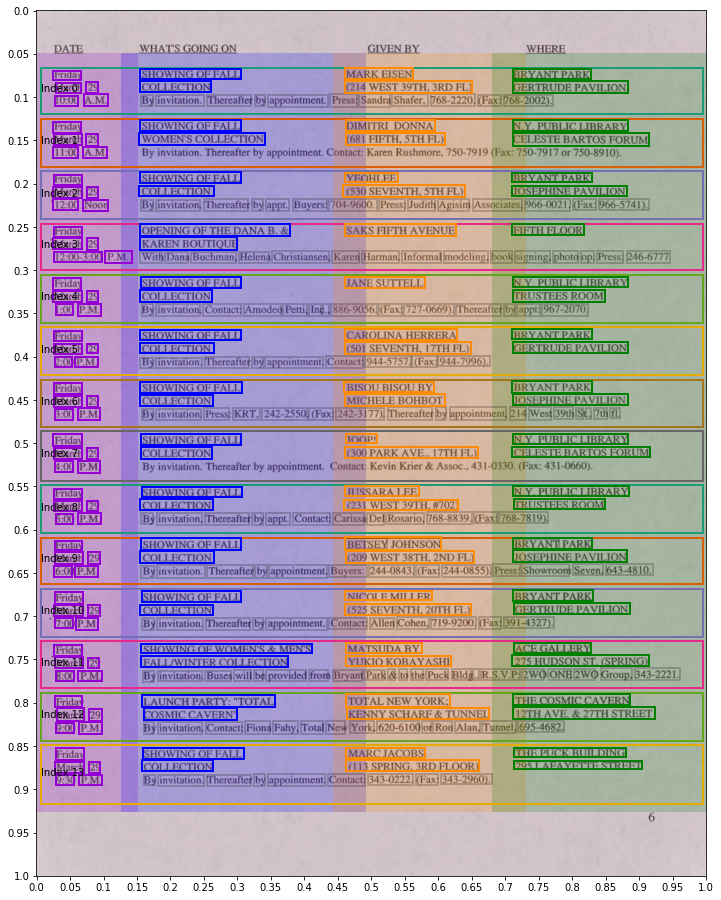

In [ ]:
fig, ax = plt.subplots(figsize=(12, 16))
plt.imshow(image)

ax.add_patch(Rectangle((when_x_min * width, ymax_when * height),
                       (when_x_max - when_x_min) * width, (ymin_copyright - ymax_when) * height,
                       facecolor='darkviolet', alpha=0.2))
ax.add_patch(Rectangle((what_x_min * width, ymax_what * height),
                       (what_x_max - what_x_min) * width, (ymin_copyright - ymax_when) * height,
                       facecolor='blue', alpha=0.2))
ax.add_patch(Rectangle((who_x_min * width, ymax_who * height),
                       (who_x_max - who_x_min) * width, (ymin_copyright - ymax_when) * height,
                       facecolor='darkorange', alpha=0.2))
ax.add_patch(Rectangle((where_x_min * width, ymax_where * height),
                       (where_x_max - where_x_min) * width, (ymin_copyright - ymax_when) * height,
                       facecolor='green', alpha=0.2))

for ix, minimum in enumerate(minimum_of_groups):
    ymin = minimum
    if ix < len(minimum_of_groups) - 1:
        ymax = minimum_of_groups[ix + 1]
    else:
        ymax = ymin_copyright
    rect = Rectangle((15, ymin * height - 10), image.shape[1] - 25, (ymax - ymin) * height - 15,
                     facecolor='none', ec=colormap(ix % 8), lw=2)
    ax.add_patch(rect)


blocks = []
for ix, (ymin, ymax) in rows.items():
    block = {}
    lowest_of_col_info = ymax
    ax.text(15, (ymax + ymin) / 2 * height - 15, f'Index {ix}')
    dates, what, who, where = [], [], [], []
    relevant_lines = filter_by_x_and_y(transformed_lines, ymin=ymin, ymax=ymax)
    relevant_words = filter_by_x_and_y(transformed_words, ymin=ymin, ymax=ymax)
    upper_lines = list(filter(lambda x: is_all_caps(x.text), relevant_lines))
    when = filter_by_x_and_y(
        relevant_words,
        when_x_min,
        when_x_max,
        ymin_adj=-0.025,
        xmax_adj=0,
        xmin_adj=0
    )
    what = filter_by_x_and_y(
        upper_lines,
        what_x_min,
        what_x_max
    )

    if what:
        who = filter_by_x_and_y(
            upper_lines,
            who_x_min,
            who_x_max,
            xmax_adj=0
        )
        where = filter_by_x_and_y(
            upper_lines,
            where_x_min,
            where_x_max,
            xmax_adj=0
        )

    if (len(who) or len(where) or len(what)) and len(what + who + where) > 1:
        what_who_where = what + who + where
        points = np.array(list(map(lambda x: x.ymax, what_who_where)))
        closest_point = np.sort(cdist(points.reshape(-1, 1), points.reshape(-1, 1)), axis=1)[:, 1]
        indices_to_keep = np.argwhere(closest_point < 0.025).ravel()
        elements_to_keep = [what_who_where[i] for i in indices_to_keep]
        lowest_of_col_info = max(list(map(lambda x: x.ymax, elements_to_keep)))
        what = filter_by_x_and_y(what, ymax=lowest_of_col_info)
        where = filter_by_x_and_y(where, ymax=lowest_of_col_info)

        description = filter_by_x_and_y(
            relevant_words,
            xmin=what_x_min,
            ymin=lowest_of_col_info
        )
        for line in description:
            rect = Rectangle((line.xmin * width, line.ymin * height),
                             (line.xmax - line.xmin) * width, (line.ymax - line.ymin) * height,
                             facecolor='None', ec='k', lw=2, alpha=0.2)
            ax.add_patch(rect)

    else:
        what = filter_by_x_and_y(transformed_lines, xmin=what_x_min, ymin=ymin, ymax=ymax)

    for line in who:
        rect = Rectangle((line.xmin * width, line.ymin * height),
                         (line.xmax - line.xmin) * width, (line.ymax - line.ymin) * height,
                         facecolor='None', ec='darkorange', lw=2)
        ax.add_patch(rect)
    for line in where:
        rect = Rectangle((line.xmin * width, line.ymin * height),
                         (line.xmax - line.xmin) * width, (line.ymax - line.ymin) * height,
                         facecolor='None', ec='green', lw=2)
        ax.add_patch(rect)
    for line in when:
        rect = Rectangle((line.xmin * width, line.ymin * height),
                         (line.xmax - line.xmin) * width, (line.ymax - line.ymin) * height,
                         facecolor='None', ec='darkviolet', lw=2)
        ax.add_patch(rect)
    for line in what:
        rect = Rectangle((line.xmin * width, line.ymin * height),
                         (line.xmax - line.xmin) * width, (line.ymax - line.ymin) * height,
                         facecolor='None', ec='blue', lw=2)
        ax.add_patch(rect)

    block['index'] = ix
    block['when'] = when
    block['what'] = what
    block['who'] = who
    block['where'] = where
    block['description'] = description
    blocks.append(block)

plt.xticks(np.linspace(0, width,  21), (np.linspace(0, width,  21) /  width).round(3))
plt.yticks(np.linspace(0, height, 21), (np.linspace(0, height, 21) / height).round(3))
plt.show()

In [ ]:
data = []
for block in blocks:
    data_subset = {}
    for name, value in block.items():
        if type(value) == list:
            text = ' '.join(map(lambda x: x.text, value))
            data_subset[name] = text
        else:
            data_subset[name] = value
    data.append(data_subset)

In [ ]:
pd.DataFrame(data)

,index,when,what,who,where,description
0,0,Friday March 29 10:00 A.M.,SHOWING OF FALL COLLECTION,"MARK EISEN (214 WEST 39TH, 3RD FL)",BRYANT PARK GERTRUDE PAVILION,By invitation. Thereafter by appointment. Pres...
1,1,Friday March 29 11:00 A.M.,SHOWING OF FALL WOMEN'S COLLECTION,"DIMITRI DONNA (681 FIFTH, 5TH FL) YEOHLEE",N.Y. PUBLIC LIBRARY CELESTE BARTOS FORUM BRYAN...,
2,2,Friday March 29 12:00 Noon,SHOWING OF FALL COLLECTION,"YEOHLEE (530 SEVENTH, 5TH FL)",BRYANT PARK JOSEPHINE PAVILION,By invitation. Thereafter by appt. Buyers: 704...
3,3,Friday March 29 12:00-3:00 P.M.,OPENING OF THE DANA B. & KAREN BOUTIQUE,SAKS FIFTH AVENUE,FIFTH FLOOR,"With Dana Buchman, Helena Christiansen, Karen ..."
4,4,Friday March 29 1:00 P.M.,SHOWING OF FALL COLLECTION,JANE SUTTELL,N.Y. PUBLIC LIBRARY TRUSTEES ROOM,"By invitation. Contact: Amodeo Petti, Inc ., 8..."
5,5,Friday March 29 2:00 P.M.,SHOWING OF FALL COLLECTION,"CAROLINA HERRERA (501 SEVENTH, 17TH FL)",BRYANT PARK GERTRUDE PAVILION,By invitation. Thereafter by appointment. Cont...
6,6,Friday March 29 3:00 P.M.,SHOWING OF FALL COLLECTION,BISOU BISOU BY MICHELE BOHBOT,BRYANT PARK JOSEPHINE PAVILION,"By invitation. Press: KRT, 242-2550. (Fax: 242..."
7,7,Friday March 29 4:00 P.M.,SHOWING OF FALL COLLECTION,"JOOP! (300 PARK AVE ., 17TH FL) JUSSARA LEE",N.Y. PUBLIC LIBRARY CELESTE BARTOS FORUM N.Y. ...,
8,8,Friday March 29 5:00 P.M.,SHOWING OF FALL COLLECTION,"JUSSARA LEE (231 WEST 39TH, #702)",N.Y. PUBLIC LIBRARY TRUSTEES ROOM,By invitation. Thereafter by appt. Contact: Ca...
9,9,Friday March 29 6:00 P.M.,SHOWING OF FALL COLLECTION,"BETSEY JOHNSON (209 WEST 38TH, 2ND FL) NICOLE ...",BRYANT PARK JOSEPHINE PAVILION,By invitation. Thereafter by appointment. Buye...
